In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from tensorflow.keras import layers as tfkl
from tensorflow.keras import models as tfk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import metrics
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [2]:
# Load Data
data = np.load('/kaggle/input/homework2/mars_for_students.npz')

training_set = data["training_set"]
y_train = training_set[:, 1]

#KIll All alients. sample [62]
mask = np.all(np.all(y_train == y_train[62], axis=1), axis=1)
index = np.where(mask)[0]
training_set = np.delete(training_set, index, axis=0)

X_train = training_set[:, 0]
y_train = training_set[:, 1]



X_test = data["test_set"]

# Add a color channel and rescale pixel values to be between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
y_train = y_train[..., np.newaxis]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


In [3]:
# Check the number of samples for each class
y_train_flat = y_train.flatten()

# Get all unique classes and their pixel counts
unique_classes, class_counts = np.unique(y_train_flat, return_counts=True)

# Total number of pixels
total_pixels = len(y_train_flat)

# Calculate class weights
num_classes = len(unique_classes)
class_weights = {}
for cls, count in zip(unique_classes, class_counts):
    class_weights[cls] = total_pixels / (num_classes * count)

print("Class Weights:", class_weights)

# Print the pixel count for each class
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} pixels")

Class Weights: {0.0: 0.8226769183771894, 1.0: 0.5898914242365618, 2.0: 0.8591909663562084, 3.0: 1.088407490884616, 4.0: 152.21570300040796}
Class 0.0: 4988826 pixels
Class 1.0: 6957538 pixels
Class 2.0: 4776810 pixels
Class 3.0: 3770823 pixels
Class 4.0: 26963 pixels


In [4]:
# Create augmented dataset for class 4.0
class_4_indices = [i for i in range(len(y_train)) if np.any(y_train[i] == 4)]

X_class_4 = X_train[class_4_indices]
y_class_4 = y_train[class_4_indices]

print("X_class_4 shape:", X_class_4.shape)
print("y_class_4 shape:", y_class_4.shape)

X_class_4 shape: (63, 64, 128, 1)
y_class_4 shape: (63, 64, 128, 1)


In [5]:
# Data augmentation for minority class (Class 4.0)
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Data augmentation
augmented_images = []
augmented_labels = []

batch_size = 64  # Use a smaller batch size

for _ in range(100):  # Perform augmentation 100 times to increase the dataset
    for X_batch, y_batch in datagen.flow(X_class_4, y_class_4, batch_size=batch_size, shuffle=False):
        augmented_images.append(X_batch)
        augmented_labels.append(y_batch)

        # Stop augmentation to prevent generating excessive samples (avoid memory issues)
        if len(augmented_images) * batch_size >= len(X_class_4):
            break

# Concatenate augmented data
X_augmented = np.concatenate(augmented_images, axis=0)
y_augmented = np.concatenate(augmented_labels, axis=0)

# Print final shapes to verify
print("X_augmented shape:", X_augmented.shape)
print("y_augmented shape:", y_augmented.shape)

# Add augmented data to the training set
X_train = np.concatenate((X_train, X_augmented), axis=0)
y_train = np.concatenate((y_train, y_augmented), axis=0)

# Print final shapes to verify
print("Final X_train shape:", X_train.shape)
print("Final y_train shape:", y_train.shape)

X_augmented shape: (6300, 64, 128, 1)
y_augmented shape: (6300, 64, 128, 1)
Final X_train shape: (8805, 64, 128, 1)
Final y_train shape: (8805, 64, 128, 1)


In [7]:
# Check the number of samples for each class
y_train_flat = y_train.flatten()
unique_classes, class_counts = np.unique(y_train_flat, return_counts=True)
total_samples = len(y_train_flat)
class_weights = [0] * unique_classes
for cls, count in zip(np.int32(unique_classes), class_counts):
    class_weights[cls] = total_samples / (len(unique_classes) * count)

print("After Data augmentation, \nClass Weights:", class_weights)
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

After Data augmentation, 
Class Weights: [0.50341103 0.99613137 1.16047529 1.04255832 5.29736276]
Class 0.0: 28656726 samples
Class 1.0: 14482138 samples
Class 2.0: 12431210 samples
Class 3.0: 13837223 samples
Class 4.0: 2723263 samples


In [8]:
# Define dataset shapes
input_shape = X_train.shape[1:]  # (64, 128, 1)
num_classes = len(np.unique(y_train))  # 5 classes (including background)

# Split the training set into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Display shapes after train-validation split
print(f"X_train shape after split: {X_train.shape}")
print(f"y_train shape after split: {y_train.shape}")
print(f"X_val shape after split: {X_val.shape}")
print(f"y_val shape after split: {y_val.shape}")

X_train shape after split: (7044, 64, 128, 1)
y_train shape after split: (7044, 64, 128, 1)
X_val shape after split: (1761, 64, 128, 1)
y_val shape after split: (1761, 64, 128, 1)


In [9]:
keras.saving.get_custom_objects().clear()
@keras.saving.register_keras_serializable(package="MyLayers")
# Define custom MeanIoU metric excluding the background class
class CustomMeanIoU(metrics.MeanIoU):
    def __init__(self, num_classes, name='custom_mean_IoU', **kwargs):
        super().__init__(num_classes=num_classes, name='custom_mean_IoU', **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.argmax(y_pred, axis=-1)
        mask = tf.not_equal(y_true, 0)  # Ignore background class (labeled as 0)
        y_true = tf.boolean_mask(y_true, mask)
        y_pred = y_pred[..., np.newaxis] 
        y_pred = tf.boolean_mask(y_pred, mask)
        return super().update_state(y_true, y_pred, sample_weight)

In [10]:
@keras.saving.register_keras_serializable(package="my_package", name="weighted_categorical_crossentropy")
def weighted_categorical_crossentropy(weights):
 
    weights = tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        # y_true and y_pred shape: (batch_size, height, width, num_classes)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.squeeze(y_true, axis=-1)
        # One-hot encode y_true (assuming it is sparse)
        y_true = tf.one_hot(y_true, depth=len(weights))
        
        # Multiply by weights
        weight_map = tf.reduce_sum(y_true * weights, axis=-1)
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        weighted_loss = loss * weight_map
        
        return tf.reduce_mean(weighted_loss)

    return loss

print(keras.saving.get_custom_objects())

{'MyLayers>CustomMeanIoU': <class '__main__.CustomMeanIoU'>, 'my_package>weighted_categorical_crossentropy': <function weighted_categorical_crossentropy at 0x79e27cc8f0a0>}


In [11]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def get_unet_model(input_shape, num_classes=5, seed=None):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 512, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 1024, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = unet_block(u1, 512, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 256, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 128, name='up_block3_')

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 64, name='up_block4_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model


model = get_unet_model(input_shape, num_classes)

In [12]:
# Compile the model
class_weights = [0, 0.2, 0.2, 0.2, 0.4]
weights = class_weights
LEARNING_RATE = 1e-2
model.compile(optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
              loss=weighted_categorical_crossentropy(weights),
              metrics=[CustomMeanIoU(num_classes=num_classes)])

# Model summary
model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        256 │ down_block1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv2   │ (None, 64, 128,   │     36,928 │ down_block1_acti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn2     │ (None, 64, 128,   │        256 │ down_block1_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn2[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        512 │ down_block2_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv2   │ (None, 32, 64,    │    147,584 │ down_block2_acti… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn2     │ (None, 32, 64,    │        512 │ down_block2_conv… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn2[… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ down_block2_acti… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_conv1   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block3_bn1     │ (None, 16, 32,    │      1,024 │ down_block3_conv

 Total params: 31,401,605 (119.79 MB)

 Trainable params: 31,389,829 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Configure ReduceLROnPlateau to adjust learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_custom_mean_IoU',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    mode='max',
    verbose=1
)

# Configure EarlyStopping to stop training on no improvement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_mean_IoU',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Set training callbacks
callbacks = [early_stopping, reduce_lr]

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    epochs=50,
    batch_size=124
)

Epoch 1/50


I0000 00:00:1734127981.721594      74 service.cc:145] XLA service 0x79e19800d500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734127981.721666      74 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734128025.637748      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - custom_mean_IoU: 0.1798 - loss: 0.1816 - val_custom_mean_IoU: 0.0333 - val_loss: 1325.2899 - learning_rate: 0.0100
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - custom_mean_IoU: 0.3355 - loss: 0.1449 - val_custom_mean_IoU: 0.0428 - val_loss: 9.7164 - learning_rate: 0.0100
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 419ms/step - custom_mean_IoU: 0.4100 - loss: 0.1292 - val_custom_mean_IoU: 0.1435 - val_loss: 0.4472 - learning_rate: 0.0100
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 416ms/step - custom_mean_IoU: 0.4557 - loss: 0.1141 - val_custom_mean_IoU: 0.1171 - val_loss: 0.3687 - learning_rate: 0.0100
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 416ms/step - custom_mean_IoU: 0.4995 - loss: 0.1054 - val_custom_mean_IoU: 0.1266 - val_loss: 0.4542 - learning_rate: 0.0100
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 417ms/step - custom_mean_IoU: 0.5441 - loss: 0.0938 - val_custom_mean_IoU: 0.1487 - val_loss: 0.4451 - learning_rate: 0.0100
Epoch 7/

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_mean_IoU',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    epochs=50,
                    batch_size=124)

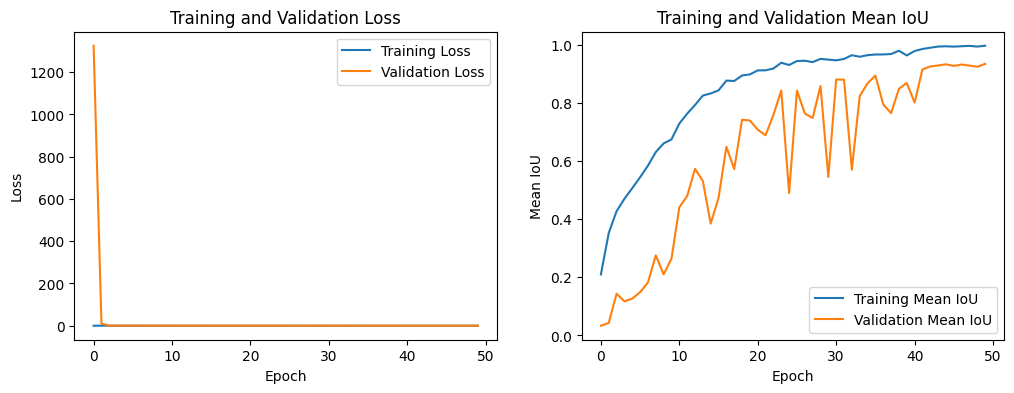

In [15]:
# Visualize Training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_mean_IoU'], label='Training Mean IoU')
plt.plot(history.history['val_custom_mean_IoU'], label='Validation Mean IoU')
plt.title('Training and Validation Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend()

plt.show()

In [16]:
# Evaluate on Validation Set
val_loss, val_miou = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Mean IoU: {val_miou}")

# Make Predictions on Test Set
test_predictions = model.predict(X_test, batch_size=32)
test_predictions = np.argmax(test_predictions, axis=-1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - custom_mean_IoU: 0.9281 - loss: 0.0259
Validation Loss: 0.02443927899003029
Validation Mean IoU: 0.9345908761024475
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step


## Prepare Your Submission

In [17]:
# Save the Model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241213_223548.keras


In [18]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [19]:
model = tfk.load_model(model_filename,
                      custom_objects={"CustomMeanIoU": CustomMeanIoU, "loss": weighted_categorical_crossentropy},)
print(f"Model loaded from {model_filename}")

Model loaded from model_241213_223548.keras


In [20]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step
Predictions shape: (10022, 64, 128)


In [21]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [22]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
from IPython.display import FileLink

FileLink(submission_filename)

/kaggle/working/submission_241213_223548.csv